In [1]:
%cd ..
import os
import time
from typing import TYPE_CHECKING, Any, Dict, List, Optional, Set, Tuple, Union

/work/apperception/shared/apperception-yousef


In [2]:
from apperception.database import database

from apperception.utils import transformation
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def fetch_camera_config(filename: str, database):
    query = f"""
    CREATE OR REPLACE FUNCTION ST_XYZ (g geometry) RETURNS real[] AS $$
        BEGIN
            RETURN ARRAY[ST_X(g), ST_Y(g), ST_Z(g)];
        END;
    $$ LANGUAGE plpgsql;

    SELECT
        cameraId,
        ST_XYZ(egoTranslation),
        egoRotation,
        ST_XYZ(cameraTranslation),
        cameraRotation,
        cameraIntrinsic,
        frameNum,
        fileName,
        cameraHeading,
        egoHeading,
        timestamp
    FROM Cameras
    WHERE
        fileName = '{filename}'
    ORDER BY cameraId ASC, frameNum ASC;
    """
    result = database.execute(query)[0]
    print(result)
    camera_config = {
        "cameraId": result[0],
        "egoTranslation": result[1],
        "egoRotation": result[2],
        "cameraTranslation": result[3],
        "cameraRotation": result[4],
        "cameraIntrinsic": result[5],
        "frameNum": result[6],
        "fileName": result[7],
        "cameraHeading": result[8],
        "egoHeading": result[9],
        "timestamp": result[10],
    }
    return camera_config

In [4]:
def fetch_trajectory(itemId: str, time: str, database):
    query = f"""
        CREATE OR REPLACE FUNCTION ST_XYZ (g geometry) RETURNS real[] AS $$
        BEGIN
            RETURN ARRAY[ST_X(g), ST_Y(g), ST_Z(g)];
        END;
        $$ LANGUAGE plpgsql;

        SELECT ST_XYZ(valueAtTimestamp(trajCentroids, '{time}'))
        FROM Item_General_Trajectory as final
        WHERE itemId = '{itemId}';
        """

    traj = database.execute(query)[0][0]
    return traj

In [5]:
def world_to_pixel(
    camera_config: dict, world_coords: Union[np.ndarray, Tuple[float, float, float]]
):
    traj_2d = transformation(world_coords, camera_config)
    return traj_2d

In [6]:
def overlay_objects(frame, itemIds: Set[str], camera_config, database):
    time = camera_config["timestamp"]
    pixels = {}
    for itemId in itemIds:
        current_traj_point = fetch_trajectory(itemId=itemId, time=time, database=database)

        if None not in current_traj_point:
            print(current_traj_point)
            current_pixel = world_to_pixel(camera_config, current_traj_point)
            print(current_pixel)
            pixels[itemId] = current_pixel

    for itemId in pixels:
        pixel = pixels[itemId]
        cv2.circle(
            frame,
            tuple([int(pixel[0][0]), int(pixel[1][0])]),
            10,
            (0, 255, 0),
            -1,
        )
    return frame

In [7]:
def overlay_bboxes(frame, bboxes):
    for i in range(len(bboxes.detections)):
        box = bboxes.detections[i]
        bbox_left, bbox_top, bbox_right, bbox_buttom, _, _  = [int(x) for x in box]
        cv2.rectangle(frame, (bbox_left, bbox_top), (bbox_right, bbox_buttom), (255, 0, 0), 2)
        cv2.putText(frame, "c" + str(1 + i), (bbox_left, bbox_buttom), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    return frame

In [9]:

import cv2
import numpy as np
import torch
from yolo_tracker.yolov5.utils.augmentations import letterbox
from yolo_tracker.yolov5.utils.general import (check_img_size,
                                               non_max_suppression,
                                               scale_boxes)
from yolo_tracker.yolov5.utils.torch_utils import select_device

from optimized_ingestion.stages.detection_2d.detection_2d import Metadatum

def class_mapping_to_list(names: "dict[int, str]") -> "list[str]":
    out: "list[str]" = []
    for i, (idx, name) in enumerate(sorted(names.items())):
        assert i == idx, (i, idx)
        out.append(name)

    return out

def detect_image(im0):
    im = letterbox(im0, 640, stride=32, auto=True)[0]  # padded resize
    im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    im = np.ascontiguousarray(im)
    
    im = torch.from_numpy(im).to(select_device(""))
    im = im.half() if False else im.float()
    im /= 255.0  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s').model.to(select_device(""))

    # Inference
    pred = model(im, augment=False)

    # Apply NMS
    pred = non_max_suppression(
        pred,
        0.25,
        0.45,
        None,
        False,
        max_det=1000
    )

    # Process detections
    assert isinstance(pred, list), type(pred)
    assert len(pred) == 1, len(pred)
    det = pred[0]
    assert isinstance(det, torch.Tensor), type(det)
    det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

    return Metadatum(det, class_mapping_to_list(model.names))


ModuleNotFoundError: No module named 'yolo_tracker'

In [10]:
prefix = "/work/apperception/data/raw/nuScenes/full-dataset-v1.0/Trainval/"
filename = "samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918662404.jpg"
# itemIds = ['scene-0757-CAM_FRONT_obj_44', 'scene-0757-CAM_FRONT_obj_23']
frame_im = cv2.imread(prefix + filename)

# camera_config = fetch_camera_config(filename, database)
# print(camera_config)
# overlayed = overlay_objects(frame_im, itemIds, camera_config, database)

In [11]:
metadata = detect_image(frame_im)

NameError: name 'detect_image' is not defined

In [12]:
overlayed = overlay_bboxes(frame_im, metadata)

NameError: name 'metadata' is not defined

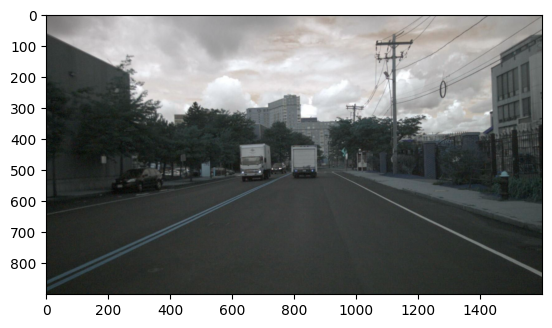

In [14]:
plt.imshow(frame_im)

In [ ]:
"""
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918662404.jpg

SELECT itemId, objectType, c.egoHeading, roadDirection(c.egoTranslation, c.egoHeading), ST_Distance(c.egoTranslation, valueAtTimestamp(t.translations, c.timestamp)), valueAtTimestamp(t.itemHeadings, c.timestamp), roadDirection(valueAtTimestamp(t.translations, c.timestamp),  valueAtTimestamp(t.itemHeadings, c.timestamp)::real) from Item_General_Trajectory AS t, Cameras AS c where t.cameraId = c.cameraId AND c.filename = 'samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918662404.jpg';